In [30]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr
# a few things to talk about 
# Getting into modeling
# Just set up the interns 

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# parameters
# gain electrons per adu
g = 3.5
# dimension 
row = 2048
column = 2048
# bias levels 
# real bias level count per pixel 
bias_real_mean = 300
# the systematic error on the bias
bias_err = 1
bias_real = np.array([[np.random.normal(bias_real_mean, bias_err) for _ in range(column)] for _ in range(row)])
# assumed bias level float up to factor of 2 
factor = 2 
# all the bias meas means 
bias_meas_mean = np.linspace(bias_real_mean/factor, bias_real_mean*factor, int(bias_real_mean*factor - bias_real_mean/factor))
# dark
# dark current elec per sec
d = 0.05
# time dark exposure
td = 60
# real dark 
d_real = d / g - bias_real / td 
# flat
# flat time 3 sec to 120 sec
tf_array = np.linspace(3, 120)
# Raw flat field frame float 10000 to 20000 per pixel
upperFlat = 10000
lowerFlat = 20000
flat_raw = np.array([[np.random.uniform(upperFlat, lowerFlat) for _ in range(column)] for _ in range(row)])
display(flat_raw)
# the two arrays to store 
percent_change_in_bias_array = []
percent_change_in_flat_array = []
tf_plot_array = []
    

array([[16023.17698472, 18588.11628827, 18544.75630634, ...,
        10781.35929265, 18626.70591892, 15320.89382605],
       [17988.75864042, 10404.2454941 , 18673.09444231, ...,
        11891.97742922, 10419.45940054, 15510.2064364 ],
       [14717.75981585, 18680.58768042, 14187.21928829, ...,
        14264.47807989, 18050.71342882, 17272.64099237],
       ...,
       [19127.53288386, 17903.47014613, 16431.52246187, ...,
        16713.00797137, 18750.20914716, 16151.00730359],
       [11715.86019408, 14917.21531432, 14431.67586425, ...,
        16286.86316343, 19458.16709372, 11802.86746854],
       [17850.30006384, 18106.74665637, 10452.05498496, ...,
        13992.9547017 , 11130.34328111, 11998.22749655]])

In [33]:
# prop
for b in bias_meas_mean:
    # bias measured in a 2d form with systematic error
    bias_meas = np.array([[np.random.normal(b, bias_err) for _ in range(column)] for _ in range(row)])
    # bias displacement in a 2d form 
    deltab = bias_real - bias_meas
    # bias change in a mean form
    percent_change_in_bias = np.mean(deltab / bias_real * 100)
    # measured dark 
    d_meas = d / g - bias_meas / td
    # for each flat exposure time 
    for tf in tf_array:
        # real flat in a 2d array form 
        flat_real = (flat_raw - d_real * tf - bias_real) / np.median(flat_raw - d_real * tf - bias_real)
        # flat measured in a 2d array form
        flat_meas = (flat_raw - d_meas * tf - bias_meas) / np.median(flat_raw - d_meas * tf - bias_meas)
        # flat displacement in a 2d 
        deltaf = flat_real - flat_meas
        # flat percent change in a mean form 
        percent_change_in_flat = np.mean(deltaf / flat_meas * 100)
        percent_change_in_bias_array.append(percent_change_in_bias)
        percent_change_in_flat_array.append(percent_change_in_flat)
        tf_plot_array.append(tf)

Text(0.5, 0, 'Percent change in Flat')

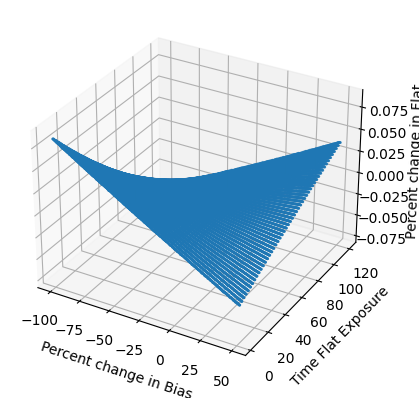

In [44]:
ax = plt.axes(projection='3d')
# Adding data to our axes, 's=40' is to increase point size by 40
ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 

# Labelling your axes
ax.set_xlabel('Percent change in Bias')
ax.set_ylabel('Time Flat Exposure')
ax.set_zlabel('Percent change in Flat')

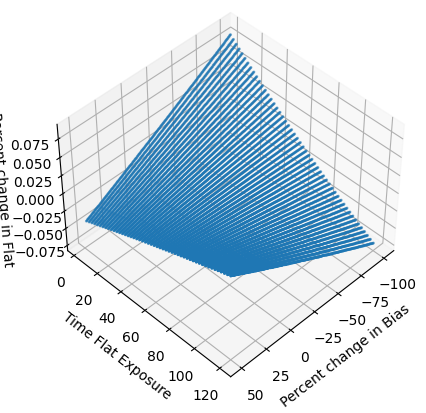

In [51]:
ax = plt.axes(projection='3d')
# Adding data to our axes, 's=40' is to increase point size by 40
ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 

# Labelling your axes
ax.set_xlabel('Percent change in Bias')
ax.set_ylabel('Time Flat Exposure')
ax.set_zlabel('Percent change in Flat')

ax.view_init(45, 45)


In [52]:
bias_meas_mean_1 = np.linspace(bias_real_mean/factor, bias_real_mean*factor)
display(bias_meas_mean_1.shape)
percent_change_in_bias_array_1 = []
percent_change_in_flat_array_1 = []
tf_plot_array_1 = []

(50,)

In [53]:
# prop
i = 0
for b in bias_meas_mean_1:
    i += 1
    display(i)
    # bias measured in a 2d form with systematic error
    bias_meas = np.array([[np.random.normal(b, bias_err) for _ in range(column)] for _ in range(row)])
    # bias displacement in a 2d form 
    deltab = bias_real - bias_meas
    # bias change in a mean form
    percent_change_in_bias = np.mean(deltab / bias_real * 100)
    # measured dark 
    d_meas = d / g - bias_meas / td
    # for each flat exposure time 
    for tf in tf_array:
        # real flat in a 2d array form 
        flat_real = (flat_raw - d_real * tf - bias_real) / np.median(flat_raw - d_real * tf - bias_real)
        # flat measured in a 2d array form
        flat_meas = (flat_raw - d_meas * tf - bias_meas) / np.median(flat_raw - d_meas * tf - bias_meas)
        # flat displacement in a 2d 
        deltaf = flat_real - flat_meas
        # flat percent change in a mean form 
        percent_change_in_flat = np.mean(deltaf / flat_meas * 100)
        percent_change_in_bias_array_1.append(percent_change_in_bias)
        percent_change_in_flat_array_1.append(percent_change_in_flat)
        tf_plot_array_1.append(tf)

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

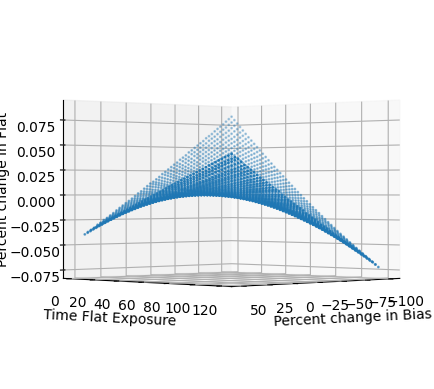

In [65]:
ax = plt.axes(projection='3d')
# Adding data to our axes, 's=40' is to increase point size by 40
ax.scatter3D(percent_change_in_bias_array_1, tf_plot_array_1, percent_change_in_flat_array_1, s=1) 

# Labelling your axes
ax.set_xlabel('Percent change in Bias')
ax.set_ylabel('Time Flat Exposure')
ax.set_zlabel('Percent change in Flat')

ax.view_init(0, 45)

In [66]:
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

In [67]:
from scipy.optimize import curve_fit
  
# Perform curve fitting
popt, pcov = curve_fit(func, (percent_change_in_bias_array, tf_plot_array), percent_change_in_flat_array)
  
# Print optimized parameters
print(popt)

[ 1.14292742e-03 -8.10813916e-04 -6.25839381e-05  1.11813864e-07
  5.30841669e-07  1.32385690e-05]


In [76]:
X, Y = np.meshgrid(percent_change_in_bias_array, tf_plot_array)
pred_flat_change = func((X, Y), *popt)




In [ ]:
ax = plt.axes(projection='3d')
# Adding data to our axes, 's=40' is to increase point size by 40
ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
ax.plot_surface(X, Y, pred_flat_change, color='red', alpha=0.5)
# Labelling your axes
ax.set_xlabel('Percent change in Bias')
ax.set_ylabel('Time Flat Exposure')
ax.set_zlabel('Percent change in Flat')
plt.show()

In [35]:
# # number of pixels in rows and columns, can change with the dimension of the CCD
# rows = 100
# columns = 100
# # dark counts per second per pixel 
# dark = 2 
# # the flactuation of flat with a 3% error
# flatUpper = 1.03
# flatLower = 0.97
# # bias counts and overall bias level change
# bias = 4000
# biasChangeUpper = 0.2
# biasChangeLower = 0.01
# # integration time 
# time = 300 

# # flat field randomization
# flatField = np.matrix([[np.random.uniform(flatLower, flatUpper) for _ in range(columns)] for _ in range(rows)])

In [36]:
# #change for the bias
# biasChange = np.linspace(biasChangeLower, biasChangeUpper)
# # flat field propagation 
# mean_displacement = []
# for b in biasChange:  
#     master_bias = np.matrix([[np.random.normal(bias, bias * b) for _ in range(columns)] for _ in range(rows)])
#     master_dark = dark * time + master_bias
#     flat = flatField - master_dark - master_bias
#     flat /= np.mean(flat)
#     displacement = np.mean(np.abs((flat - flatField)) / flatField)
#     mean_displacement.append(displacement) 
    
# plt.plot(biasChange, mean_displacement, 'o')
# plt.title("BiasPropagation")
# plt.xlabel('BiasChange')
# plt.ylabel('Displacement')
# plt.show()

In [37]:
# fit = np.polyfit(biasChange, mean_displacement,1,full=False, cov=True)

# # Fit parameters are the first element in the returned "tuple"
# fitparams = fit[0]
# slope = fitparams[0]
# intercept = fitparams[1]

# # Covariance matrix is the second element in the returned "tuple"
# cov = fit[1]

# # This is the way you get errors out of the covariance matrix.
# param_error = np.sqrt(np.diagonal(cov))
# slope_error = param_error[0]
# intercept_error = param_error[1]

# slope_output = 'slope is %.3f +/- %0.3f' %(slope,slope_error)
# intercept_output = 'intercept is %.3f +/- %0.3f' %(intercept,intercept_error)

# plt.errorbar(biasChange,mean_displacement)
# plt.xlabel('Bias')
# plt.ylabel('Mean Displacement (flat - flatPrime) / flatPrime')
# xfit = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
# yfit = intercept + slope*xfit
# plt.plot(xfit,yfit,'r--', label='Linear output with ' + slope_output + intercept_output)
# plt.legend()

# print('The slope is %.3f +/- %0.3f' %(slope,slope_error))
# print('The intercept is %.3f +/- %0.3f' %(intercept,intercept_error))
# # plt.savefig('Updated Linear model')